In [1]:
# On importe notre librairie de pré-traitement
import os
import sys
sys.path.append(os.path.dirname( os.path.dirname( os.path.abspath('dionysos') ) ) )
from prevision.xg_model import *

# Pre-processing

On importe les données sur les ventes, la méteo et les attendance des évenements autours de la cage aux sports. On crée ensuite un dictionnaire. On note alors:

* X les variables d'entrée de notre modèle
* y la variable de sortie de notre modèle


In [2]:
chemin_fichier_csv = os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('dionysos'))),'prevision', 'data')
X,y = pre_process.get_data(big_chemin = chemin_fichier_csv + '/')

# on affiche les 5 premières lignes de notre dataset
print(X.head())
print("\n")
# on affiche les 5 premières lignes de notre target
print(y.head())


   attendance  prevision  apparent_temperature_mean (°C)  rain_sum (mm)  \
3     18692.0     9000.0                            -7.5            0.0   
4     43576.0    14000.0                           -10.0            0.1   
5     29462.0    16000.0                            -7.5            0.0   
6     74643.0    22000.0                            -5.9            0.0   
7     69394.0    20000.0                            -8.2            0.0   

   snowfall_sum (cm)  day_0  day_1  day_2  day_3  day_4  day_5  day_6  
3               0.00      1      0      0      0      0      0      0  
4               1.47      0      1      0      0      0      0      0  
5               0.00      0      0      1      0      0      0      0  
6               0.00      0      0      0      1      0      0      0  
7               0.00      0      0      0      0      1      0      0  


3     7142.63
4    13997.38
5    18136.16
6    19975.51
7    18626.76
Name: vente, dtype: float64


On remarque que les prévisions sont dans les valeurs X mais elle ne seront pas prise en compte par la suite dans notre modèle. On split ensuite nos données en données d'entrainement et de test en récuperant les previsions de la cage actuelle qui seront utilisées pour tester notre modèle.

In [3]:
X_train, X_test, y_train, y_test, prevision_cage = pre_process.split(X, y,random_state = 7)

# Modèle

## Modèle Xg Boost 

On utilise un modèle xg Boost pour prédire les ventes de la cage aux sports. On utilise une cross validation (Random search) pour trouver les meilleurs hyper-paramètres du modèle. On utilise ensuite ces hyper-paramètres pour entrainer notre modèle sur les données d'entrainement. On affiche ensuite les résultats de notre modèle sur les données de test.

### Hyper-paramètres




INFO:root:[02/06/2023 15:05:39] Recherche des meilleurs hyperparamètres


Fitting 5 folds for each of 10 candidates, totalling 50 fits


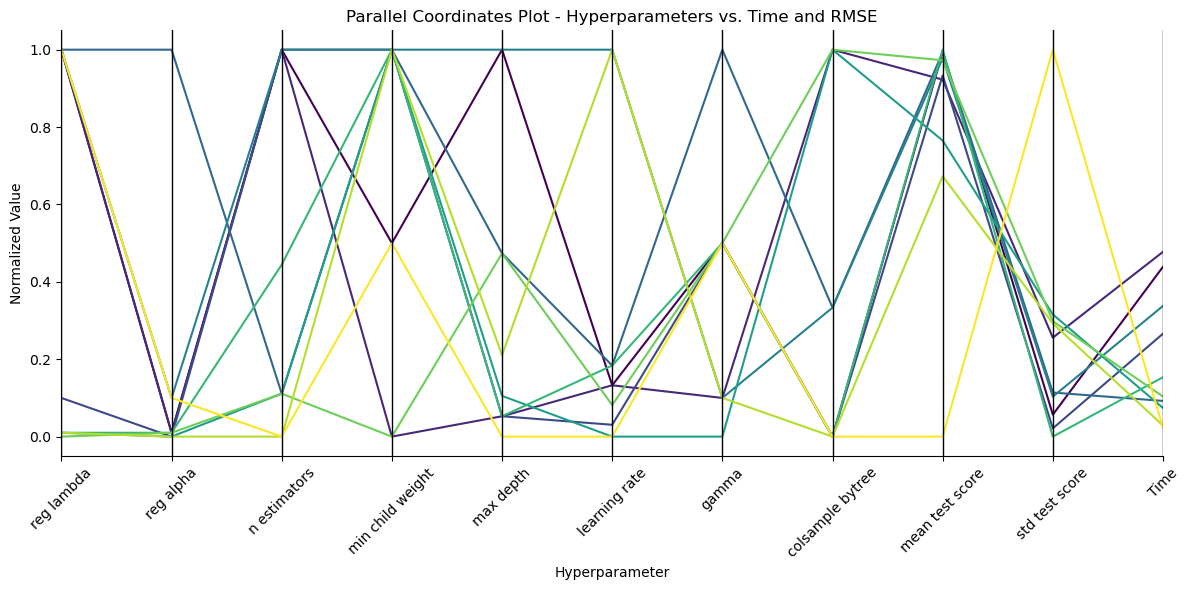

Meilleurs hyperparamètres : {'subsample': 0.8, 'reg_lambda': 0.01, 'reg_alpha': 0.01, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 0.5, 'colsample_bytree': 0.2}
RMSE : 3388.9398082285597


In [4]:
lg.info("[" + str(datetime.now().strftime("%d/%m/%Y %H:%M:%S")) + "] Recherche des meilleurs hyperparamètres")
best_params, best_model = modele_xg.hyperparametres_random(X_train, y_train, X_test, y_test,plot = True)

### Impacte des features

On affiche l'impacte des features sur les prédictions de notre modèle.

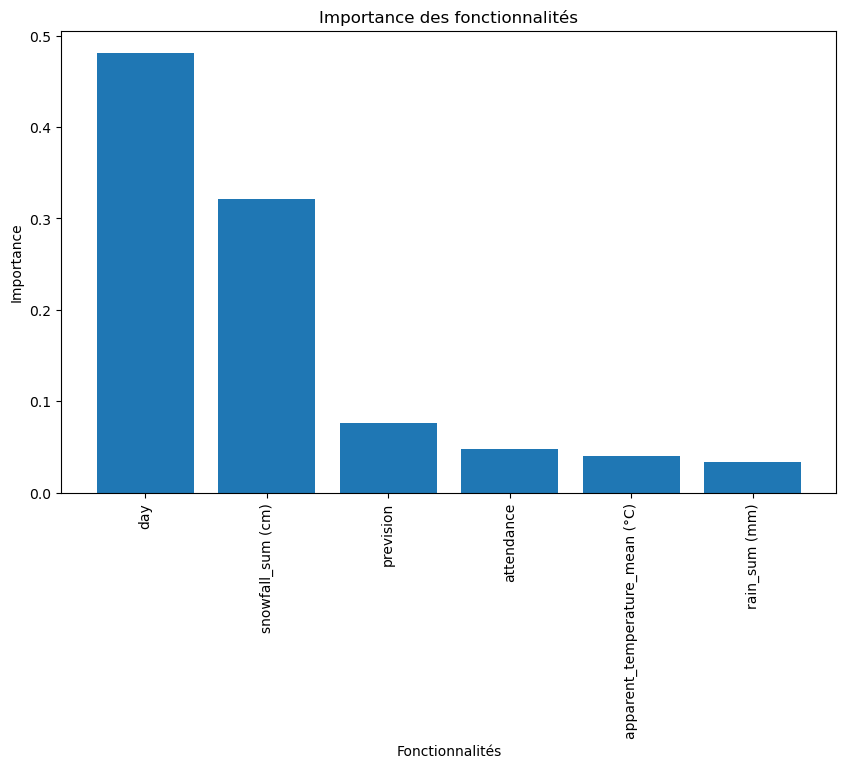

In [37]:

# Obtenir l'importance des fonctionnalités
importance = best_model.feature_importances_
# Triez les fonctionnalités par importance décroissante
feature_names = (X.columns).tolist()

# somme l'importance des day_0, day_1, day_2, day_3, day_4, day_5, day_6 en une seule colonne day
importance[5] = importance[5] + importance[6] + importance[7] + importance[8] + importance[9] + importance[10]
importance = np.delete(importance, [6,7,8,9,10])
feature_names = np.delete(feature_names, [5,6,7,8,9,10,11])
feature_names = feature_names.tolist()
feature_names.append('day')
feature_names = np.array(feature_names)
indices = np.argsort(importance)[::-1]

# Tracer un graphique de l'importance des fonctionnalités
plt.figure(figsize=(10, 6))
plt.bar(range(len(importance)), importance[indices], tick_label=feature_names[indices].tolist())
plt.xticks(rotation=90)
plt.xlabel('Fonctionnalités')
plt.ylabel('Importance')
plt.title('Importance des fonctionnalités')
plt.show()

In [36]:
importance[indices]
feature_names[indices]

TypeError: only integer scalar arrays can be converted to a scalar index

In [13]:
indices 

array([ 4, 10,  9,  7,  1,  8,  0,  6,  2,  5,  3])

### Comparaison avec les prévisions de planifico 

Notre prevision : Mean Absolute Error : 11484913.023796229
Prévision cage : Mean Absolute Error : 8676581.133768748


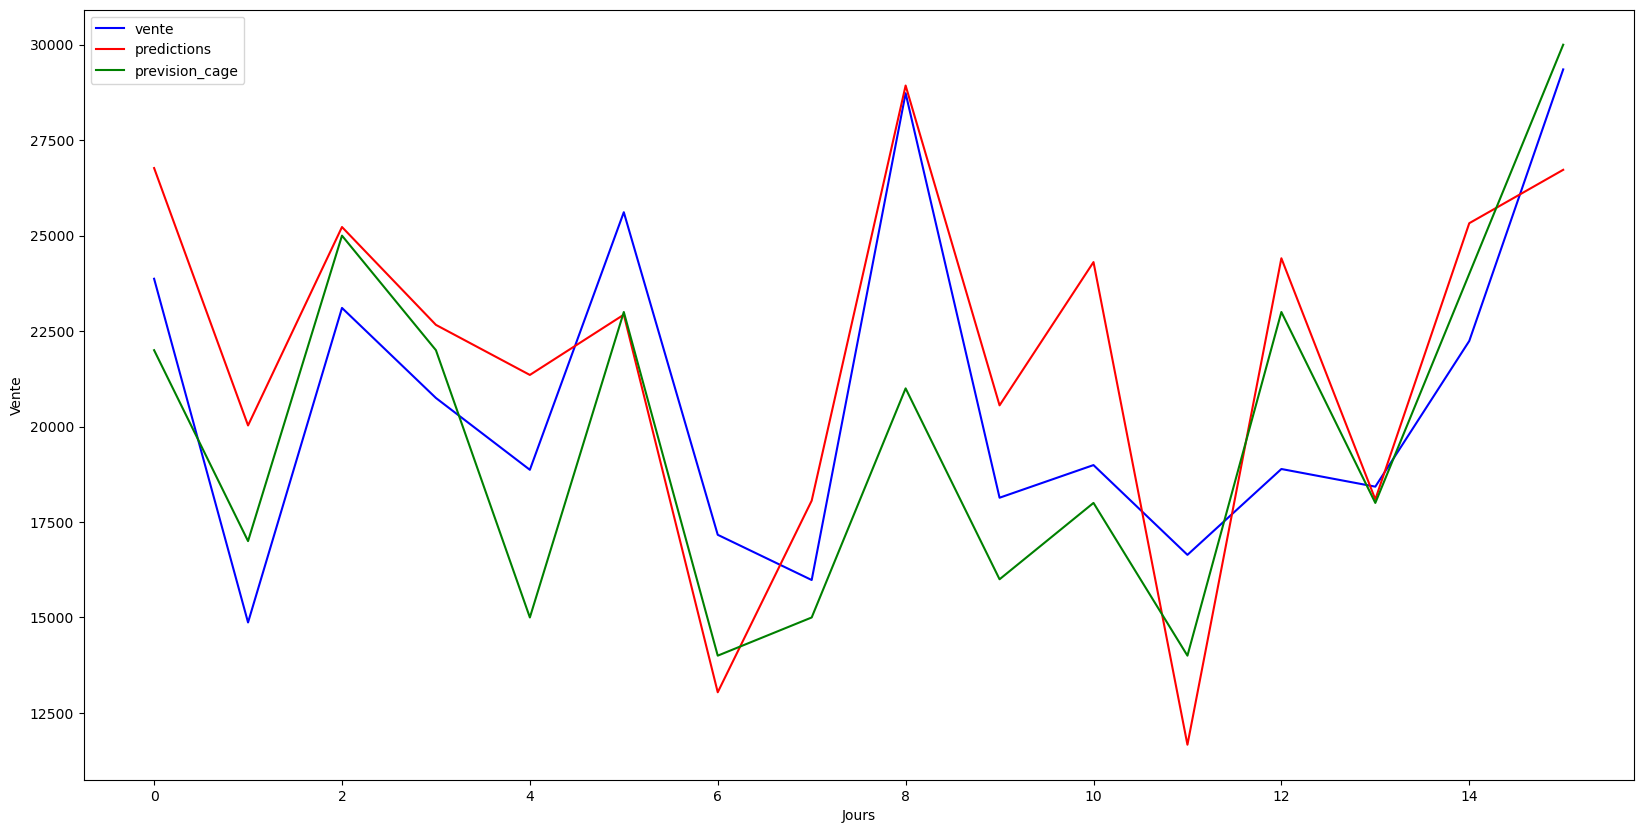

In [6]:
erreur_model,erreur_cage = modele_xg.compare2planifico(best_model,X_test,y_test,prevision_cage,plot = True)

Test à faire: 

* Faire grid sheet avec les données de ventes
* Voir l'impact des variables 